### MSE - T-MachLe
# PW 06

{dorian.magnin, noemien.kocher}@master.hes-so.ch

## Exercice 1 Digit classification system using different SVM classifiers

### a. Getting the training and test sample sets from the MNIST database

#### a) Load MNIST digit dataset. Refer to : http://deeplearning.net/tutorial/gettingstarted.html.

In [3]:
import _pickle as cPickle, gzip, numpy
import pandas as pd

# Load the dataset
train_set, validation_set, test_set = pd.read_pickle("data/mnist.pkl.gz")

print(train_set)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), array([5, 0, 4, ..., 8, 4, 8]))


#### b) Visualize (plot) the image

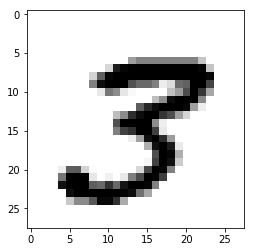

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# The rest of columns are pixels
pixels = train_set[0][203]

# Make those columns into a array of 8-bits pixels
# This array will be of 1D with length 784
# The pixel intensity values are integers from 0 to 255
pixels = np.array(pixels, dtype='float32')

# Reshape the array into 28 x 28 array (2-dimensional array)
pixels = pixels.reshape((28, 28))

plt.imshow(pixels, cmap='gray_r')
plt.show()


#### c) Build the final trainning and test set balanced

In [5]:
from collections import defaultdict
from numpy import random

def getBalabcedIndices(data, max=0):
    
    smallest_label_count = max
    if max == 0: 
        labels_count = defaultdict(int)
        # We find the minimum data items for a class
        for i in range(len(data[1])):
            label = data[1][i]
            labels_count[label] = labels_count[label] + 1
        smallest_label_count = labels_count[min(labels_count, key=labels_count.get)]
    
    indices_dict = defaultdict(list) # to keep trace of selected items
    indices = []
    
    # We won't iterate sequentially so we
    # maximise our chances to have sparse data
    lis = list(range(len(data[0])))
    random.shuffle(lis)
    for i in lis:
        label = data[1][i]
        if len(indices_dict[label]) < smallest_label_count:
            indices_dict[label].append(i)
            indices.append(i)
            
    # Quick test        
    for i in range(10):
        assert len(indices_dict[i]) == smallest_label_count
    assert len(indices) == smallest_label_count * 10
    print("Asserts Ok")
    
    return indices, smallest_label_count
    
train_balanced_indices, n1 = getBalabcedIndices(train_set, 200)
test_balanced_indices, n2 = getBalabcedIndices(test_set, 100)

print("Number per class for training set: ", n1)
print("Number per class for test set: ", n2)

def balancedTrainX():
    return [train_set[0][i] for i in train_balanced_indices]


def balancedTrainY():
    return [train_set[1][i] for i in train_balanced_indices]


def balancedTestX():
    return [test_set[0][i] for i in test_balanced_indices]


def balancedTestY():
    return [test_set[1][i] for i in test_balanced_indices]

#print(balancedTrainX())
#print(train_balanced_indices)

Asserts Ok
Asserts Ok
Number per class for training set:  200
Number per class for test set:  100


### b. Classification of digits based on raw pixel values using SVM and different kernels

Create, train and test several SVM classifiers with different kernels (linear, polynomial, RBF,...). For the training, perform a cross-validation using 10 folds, and test different with several C and kernel parameter values (e.g. for γ for RBF kernel) in order to get the best classifier. After the test, display the classification performances and confusion matrix of each SVM classifier (see class metrics):

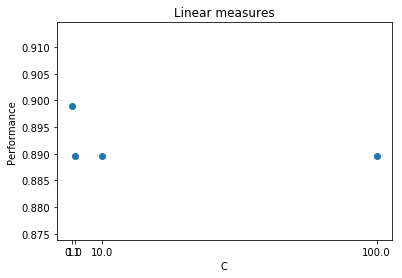

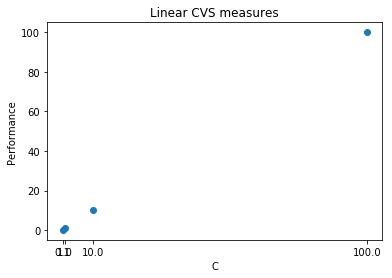

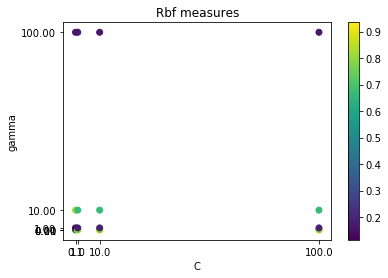

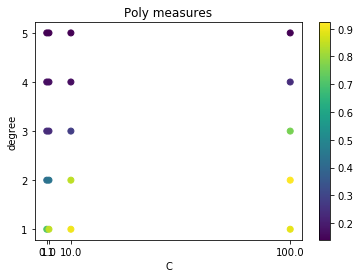

'\nmodels = (svm.SVC(kernel=\'linear\', C=C),\n          svm.LinearSVC(C=C),\n          svm.SVC(kernel=\'rbf\', gamma=0.7, C=C),\n          svm.SVC(kernel=\'poly\', degree=3, C=C))\n\nmodels = (clf.fit(balancedTrainX(), balancedTrainY()) for clf in models)\n\n\nfor clf in models:\n    print("Cross val score: ", np.mean(cross_val_score(clf, balancedTestX(), \n                                               balancedTestY(), \n                                               cv=fold_size)))\n'

In [54]:
from builtins import range

from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed
import concurrent.futures


fold_size = 10

C = 1.0  # SVM regularization parameter

#Cs = np.arange(1, 6, 1, dtype='float')
Cs = [0.1, 1, 10, 100]
#gammas = np.arange(1, 6, 1, dtype='float')
gammas = [0.001, 0.01, 0.1, 1, 10, 100]
#degrees = np.arange(1, 6, 1, dtype='int')
degrees = [1, 2, 3, 4, 5]

linear_measures = []
linearCVS_measures = []
rbf_measures = []
poly_measures = []
'''
for c in Cs:
    # linear
    model = svm.SVC(kernel='linear', C=c)
    model.fit(balancedTrainX(), balancedTrainY())
    res = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
    linear_measures.append(res)
    
    # linearCVS
    model = svm.LinearSVC(C=C)
    model.fit(balancedTrainX(), balancedTrainY())
    res = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
    linearCVS_measures.append(res)
    
    # rbf
    res = []
    for gamma in gammas:
        model = svm.SVC(kernel='rbf', gamma=gamma, C=c)
        res.append(np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size)))
    rbf_measures.append(res)
    
    # poly
    res = []
    for degree in degrees:
        model = svm.SVC(kernel='poly', degree=degree, C=c)
        res.append(np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size)))
    poly_measures.append(res)
'''    


def f1(c):
    # linear

    model = svm.SVC(kernel='linear', C=c)
    model.fit(balancedTrainX(), balancedTrainY())
    res = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
        
    return res


def f2(c):
    # linearCVS
    model = svm.LinearSVC(C=c)
    model.fit(balancedTrainX(), balancedTrainY())
    res = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
    return res
    

def f3(c):
    # rbf
    res = []
    for gamma in gammas:
        model = svm.SVC(kernel='rbf', gamma=gamma, C=c)
        score = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
        res.append([c, gamma, score])
    return res


def f4(c):
    # poly  
    res = []
    for degree in degrees:
        model = svm.SVC(kernel='poly', degree=degree, C=c)
        score = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
        res.append([c, degree, score])
    return res


with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    #future1 = executor.submit(f1)
    #future2 = executor.submit(f2)
    #future3 = executor.submit(f3)
    #future4 = executor.submit(f4)
    #linear_measures = future1.result()
    #linearCVS_measures = future2.result()
    #rbf_measures = future3.result()
    #poly_measures = future4.result()
    
    for c, res in zip(Cs, executor.map(f1, Cs)):
        linear_measures.append([c, res])
    
    for c, res in zip(Cs, executor.map(f2, Cs)):
        linearCVS_measures.append([c, res])

    for c, res in zip(Cs, executor.map(f3, Cs)):
        rbf_measures = rbf_measures + res

    for c, res in zip(Cs, executor.map(f4, Cs)):
        poly_measures = poly_measures + res

#print("Lin me: ", linear_measures)
#print("Poly me: ", poly_measures)

nm = len(linear_measures)
plt.scatter([linear_measures[i][0] for i in range(nm)], [linear_measures[i][1] for i in range(nm)])
plt.title("Linear measures")
plt.xlabel("C")
plt.xticks(Cs)
plt.ylabel("Performance")
plt.show()

nm = len(linearCVS_measures)
plt.scatter([linearCVS_measures[i][0] for i in range(nm)], [linearCVS_measures[i][0] for i in range(nm)])
plt.title("Linear CVS measures")
plt.xlabel("C")
plt.xticks(Cs)
plt.ylabel("Performance")
plt.show()

#print(rbf_measures)

nm = len(rbf_measures)
plt.scatter( [rbf_measures[i][0] for i in range(nm)], [rbf_measures[i][1] for i in range(nm)], 
             c=[rbf_measures[i][2] for i in range(nm)], cmap='viridis' )
plt.title("Rbf measures")
plt.xlabel("C")
plt.xticks(Cs)
plt.ylabel("gamma")
plt.yticks(gammas)
plt.colorbar()
plt.show()


nm = len(poly_measures)
plt.scatter( [poly_measures[i][0] for i in range(nm)], [poly_measures[i][1] for i in range(nm)], 
             c=[poly_measures[i][2] for i in range(nm)], cmap='viridis' )
plt.title("Poly measures")
plt.xlabel("C")
plt.xticks(Cs)
plt.ylabel("degree")
plt.yticks(degrees)
plt.colorbar()
plt.show()

'''
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))

models = (clf.fit(balancedTrainX(), balancedTrainY()) for clf in models)


for clf in models:
    print("Cross val score: ", np.mean(cross_val_score(clf, balancedTestX(), 
                                               balancedTestY(), 
                                               cv=fold_size)))
'''

J'ai dû me résoudre à prendre des intervals de test restreinds à cause du temps de calcul, et ce malgré une implémentation multi-process.

Mes graphiques pourraient être améliorés, mais c'est dur de faire plusieurs changements quand ça demande plus d'une heure de rendu à chaque fois.

Basé sur les résultats, je prendrais les valeurs suivantes:

* linear: c = 0.1
* linear CSV: c = 100
* rbf: C = 1, gamma = 0.001
* Poly: C = 10, degree = 1

In [60]:
from sklearn.metrics import confusion_matrix

# Linear
c = 0.1

model = svm.SVC(kernel='linear', C=c)
model.fit(balancedTrainX(), balancedTrainY())

y_true = balancedTestY()

y_pred = model.predict(balancedTestX())

conf_mat = confusion_matrix(y_true, y_pred)

score = model.score(balancedTestX(), balancedTestY())

print("linear:")
print("score: ", score)
print("cf:\n", conf_mat)

# Linear SVC
c = 100

model = svm.LinearSVC(C=c)
model.fit(balancedTrainX(), balancedTrainY())

y_true = balancedTestY()

y_pred = model.predict(balancedTestX())

conf_mat = confusion_matrix(y_true, y_pred)

score = model.score(balancedTestX(), balancedTestY())

print("SVC:")
print("score: ", score)
print("cf:\n", conf_mat)

# RBF
c = 1
gamma = 0.001

model = svm.SVC(kernel='rbf', gamma=gamma, C=c)
model.fit(balancedTrainX(), balancedTrainY())

y_true = balancedTestY()

y_pred = model.predict(balancedTestX())

conf_mat = confusion_matrix(y_true, y_pred)

score = model.score(balancedTestX(), balancedTestY())

print("RBF:")
print("score: ", score)
print("cf:\n", conf_mat)


# Poly
c = 10
degree = 1

model = svm.SVC(kernel='poly', degree=degree, C=c)
model.fit(balancedTrainX(), balancedTrainY())

y_true = balancedTestY()

y_pred = model.predict(balancedTestX())

conf_mat = confusion_matrix(y_true, y_pred)

score = model.score(balancedTestX(), balancedTestY())

print("Poly:")
print("score: ", score)
print("cf:\n", conf_mat)

linear:
score:  0.91
cf:
 [[ 97   0   0   0   0   1   1   1   0   0]
 [  0 100   0   0   0   0   0   0   0   0]
 [  0   0  85   3   2   0   5   1   4   0]
 [  0   1   2  96   0   1   0   0   0   0]
 [  0   0   1   0  95   0   0   2   0   2]
 [  1   2   1   5   1  84   2   0   3   1]
 [  3   0   2   0   0   2  93   0   0   0]
 [  0   2   1   0   0   0   0  93   2   2]
 [  0   4   1   1   2   5   3   1  83   0]
 [  2   0   0   1   7   0   0   3   3  84]]


SVC:
score:  0.838
cf:
 [[98  0  0  1  0  0  0  1  0  0]
 [ 0 98  0  1  0  0  1  0  0  0]
 [ 1  3 68  8  2  3  5  0  8  2]
 [ 1  2  3 83  1  4  0  0  3  3]
 [ 0  0  0  0 89  2  1  0  2  6]
 [ 1  1  1  6  1 76  2  1 10  1]
 [ 1  0  1  1  1  2 93  1  0  0]
 [ 0  0  1  1  0  0  0 89  2  7]
 [ 1  4  3  3  1  8  5  0 73  2]
 [ 2  1  1  2 10  1  0  7  5 71]]


RBF:
score:  0.89
cf:
 [[ 97   0   0   0   0   2   0   1   0   0]
 [  0 100   0   0   0   0   0   0   0   0]
 [  1   0  77   3   2   1   6   1   8   1]
 [  0   2   2  84   0   5   0   1   6   0]
 [  0   0   1   0  92   0   0   0   0   7]
 [  0   2   1   3   2  87   2   0   2   1]
 [  1   2   1   0   1   1  94   0   0   0]
 [  0   3   1   0   0   0   0  92   2   2]
 [  1   2   1   1   1   7   3   0  83   1]
 [  1   0   0   2   7   0   1   3   2  84]]


Poly:
score:  0.906
cf:
 [[ 98   0   0   0   0   1   0   1   0   0]
 [  0 100   0   0   0   0   0   0   0   0]
 [  1   0  79   3   2   0   6   1   8   0]
 [  0   1   2  92   0   3   0   0   2   0]
 [  0   0   1   0  96   0   0   1   0   2]
 [  0   2   1   5   1  86   3   0   2   0]
 [  3   0   2   0   2   2  91   0   0   0]
 [  0   3   1   0   0   0   0  93   2   1]
 [  0   2   0   1   1   4   4   1  87   0]
 [  2   0   0   2   8   0   0   2   2  84]]


### d. Analysis of the results

Analyse the results obtained with the best SVM classifier.

a) Which kernel and parameters were used ?  

* linear: c = 0.1
* linear CSV: c = 100
* rbf: C = 1, gamma = 0.001
* Poly: C = 10, degree = 1

b) Which digit classes are the best/worse recognized against which ? Why ? 

Le chiffre deux (2) est le moins bien reconnu, il est souvent confondu avec le 8. Et ça peut se comprendre car le 8 à la même courbe que le 2 mais en plus complet. Et le un (1) est celui qui est le mieux reconnu.
 
c) What is the impact of the sizes of the training and test sets on the classification perfor- mance ?

Pour nous, le plus grand impact est le temps de clacul... Sinon il faut que le training set soit assez grand par rapport au nombre de features pour permettre un apprentissage pertinent.